In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py

import os, time, math, string, re

from tqdm import tqdm

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, Bidirectional, GRU, GlobalMaxPool1D  
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
train = pd.read_csv("/content/drive/MyDrive/Colab Folder/Quora Insincere Question/train.csv") 
test = pd.read_csv("/content/drive/MyDrive/Colab Folder/Quora Insincere Question/test.csv")

In [4]:
print("Shape of train is :", train.shape)
train.head(3)

Shape of train is : (1306122, 3)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0


In [5]:
print("Shape of test is :", test.shape)
test.head(3) 

Shape of test is : (375806, 2)


,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...


In [6]:
target_count = train['target'].value_counts()

trace = go.Bar(
    x=target_count.index,
    y=target_count.values,
    marker=dict(
        color=target_count.values,
        colorscale='Picnic',
        reversescale=True
    ),
)

layout = go.Layout(
    title='Target Count',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='TargetCount')

In [7]:
labels = (np.array(target_count.index))
sizes = (np.array((target_count/target_count.sum()) * 100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=18),
    width=600,
    height=600
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='usertype')

# Data Preprocessing for Embedding

I want to illustrate how I do come up with meaningful preprocessing when building deep learning NLP models.

I start with two golden rules:
### 1. Don't use standard preprocessing steps like stemming or stopword removal when you have pre-trained embeddings

Some of you might used standard preprocessing steps when doing word count based feature extraction (e.g. TFIDF) such as removing stopwords, stemming etc. The reason is simple: You loose valuable information, which would help your NN to figure things out.
### 2. Get your vocabulary as close to the embeddings as possible

I will focus in this notebook, how to achieve that.


In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                       "cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", 
                       "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", 
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", 
                       "I'll": "I will", "I'll've": "I will have","I'm": "I am", 
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
                       "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", 
                       "it'd've": "it would have", "it'll": "it will", 
                       "it'll've": "it will have","it's": "it is", "let's": "let us", 
                       "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                       "mightn't": "might not","mightn't've": "might not have", 
                       "must've": "must have", "mustn't": "must not", 
                       "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", 
                       "oughtn't": "ought not", "oughtn't've": "ought not have", 
                       "shan't": "shall not", "sha'n't": "shall not", 
                       "shan't've": "shall not have", "she'd": "she would", 
                       "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", 
                       "should've": "should have", "shouldn't": "should not", 
                       "shouldn't've": "should not have", "so've": "so have",
                       "so's": "so as", "this's": "this is","that'd": "that would", 
                       "that'd've": "that would have", "that's": "that is", 
                       "there'd": "there would", "there'd've": "there would have", 
                       "there's": "there is", "here's": "here is","they'd": "they would", 
                       "they'd've": "they would have", "they'll": "they will", 
                       "they'll've": "they will have", "they're": "they are", 
                       "they've": "they have", "to've": "to have", "wasn't": "was not", 
                       "we'd": "we would", "we'd've": "we would have", "we'll": "we will", 
                       "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                       "weren't": "were not", "what'll": "what will", 
                       "what'll've": "what will have", "what're": "what are",  
                       "what's": "what is", "what've": "what have", "when's": "when is", 
                       "when've": "when have", "where'd": "where did", "where's": "where is", 
                       "where've": "where have", "who'll": "who will", 
                       "who'll've": "who will have", "who's": "who is", "who've": "who have", 
                       "why's": "why is", "why've": "why have", "will've": "will have", 
                       "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", 
                       "wouldn't've": "would not have", "y'all": "you all", 
                       "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have","you'd": "you would",
                       "you'd've": "you would have", "you'll": "you will", 
                       "you'll've": "you will have", "you're": "you are", "you've": "you have" }

def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text


In [9]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", 
                 "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', 
                 '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 
                 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 
                 'π': 'pi', }

def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

In [10]:
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 
                'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 
                'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist',
                'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 
                'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 
                'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 
                'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', 
                '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 
                'demonitisation': 'demonetization', 'demonitization': 'demonetization', 
                'demonetisation': 'demonetization', 'pokémon': 'pokemon'}

def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x


In [11]:
# Converting to lower case
train['question_text'] = train['question_text'].apply(lambda x: x.lower())

# Clean contrction
train['question_text'] = train['question_text'].apply(lambda x: clean_contractions(x, contraction_mapping))

# Special Character
train['question_text'] = train['question_text'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))

# Spelling mistakes
train['question_text'] = train['question_text'].apply(lambda x: correct_spelling(x, mispell_dict))


# What you need to do for more cleaning/preprocessing?

    Remove unknown word
    Replace acronyms with a same meaning word



In [12]:
## some config values 
embed_size = 300 
max_features = 50000 
maxlen = 100 

In [13]:
X = train['question_text'].values
y = train['target'].values 

test_x = test['question_text'].values  

In [14]:
train_x, valid_x, train_y, valid_y = train_test_split(X, y, 
                                                      test_size=.1, 
                                                      random_state=42,
                                                      stratify=y
                                                     )

In [15]:
print(len(train_x), len(valid_x), len(train_y), len(valid_y))

1175509 130613 1175509 130613


In [16]:
tokenizer = Tokenizer(num_words=max_features)
#full_text = list(train_x) + list(valid_x) 
tokenizer.fit_on_texts(train_x) 

In [17]:
train_x = tokenizer.texts_to_sequences(train_x)
valid_x = tokenizer.texts_to_sequences(valid_x)
test_x = tokenizer.texts_to_sequences(test_x)


## Pad the sentences 
train_x = pad_sequences(train_x, maxlen=maxlen)
valid_x = pad_sequences(valid_x, maxlen=maxlen)
test_x = pad_sequences(test_x, maxlen=maxlen)



# using Glove Pretrained Embedding

We have four different types of embeddings.

GoogleNews-vectors-negative300 - https://code.google.com/archive/p/word2vec/

glove.840B.300d - https://nlp.stanford.edu/projects/glove/

paragram_300_sl999 - https://cogcomp.org/page/resource_view/106

wiki-news-300d-1M - https://fasttext.cc/docs/en/english-vectors.html

A very good explanation for different types of embeddings are given in this kernel. Please refer the same for more details..


In [18]:
glove_emb = '/content/drive/MyDrive/Colab Folder/Quora Insincere Question/glove.840B.300d.txt' 

def get_coefs(word,*arr): 
  return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(glove_emb))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]


word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [19]:
input = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(input)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input, outputs=x)


In [20]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17    

In [22]:
checkpoints = ModelCheckpoint('weight.hdf5', 
                               monitor='val_loss', 
                               mode='max', 
                               verbose=True, 
                               save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=2, 
                              verbose=1, 
                              min_lr=0.000001)

In [23]:
history = model.fit(train_x, train_y, 
          batch_size=512, 
          epochs=12, 
          validation_data=(valid_x, valid_y),
          callbacks=[checkpoints, reduce_lr])

Epoch 1/12
2296/2296 [==============================] - 694s 288ms/step - loss: 0.1531 - accuracy: 0.9465 - val_loss: 0.1085 - val_accuracy: 0.9566

Epoch 00001: val_loss improved from -inf to 0.10849, saving model to weight.hdf5
Epoch 2/12
2296/2296 [==============================] - 650s 283ms/step - loss: 0.0983 - accuracy: 0.9608 - val_loss: 0.1059 - val_accuracy: 0.9579

Epoch 00002: val_loss did not improve from 0.10849
Epoch 3/12
2296/2296 [==============================] - 641s 279ms/step - loss: 0.0822 - accuracy: 0.9670 - val_loss: 0.1132 - val_accuracy: 0.9577

Epoch 00003: val_loss improved from 0.10849 to 0.11317, saving model to weight.hdf5
Epoch 4/12
2296/2296 [==============================] - 653s 285ms/step - loss: 0.0660 - accuracy: 0.9738 - val_loss: 0.1306 - val_accuracy: 0.9550

Epoch 00004: val_loss improved from 0.11317 to 0.13062, saving model to weight.hdf5

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/12
2296/2296 [

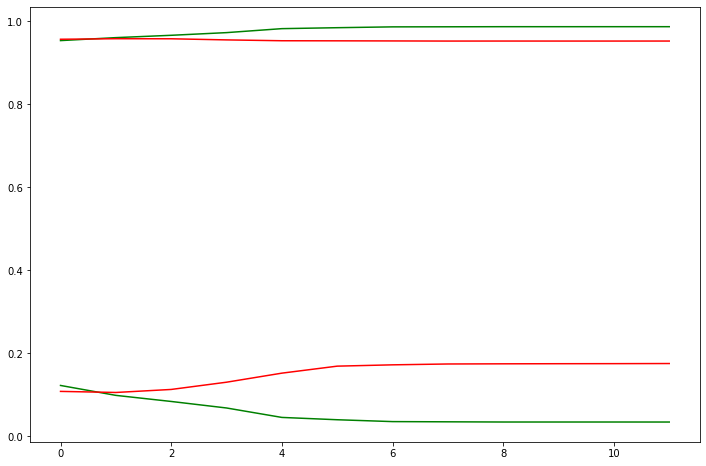

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.plot(history.history['loss'], label='Train Loss', color='green')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')

In [27]:
pred_val_y = model.predict([valid_x], batch_size=1024, verbose=1)

for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {} is {}".format(thresh, f1_score(valid_y, (pred_val_y > thresh).astype(int))))


128/128 [==============================] - 10s 73ms/step
F1 score at threshold 0.1 is 0.5937973532680068
F1 score at threshold 0.11 is 0.597843307609751
F1 score at threshold 0.12 is 0.6009316770186336
F1 score at threshold 0.13 is 0.6021156263091747
F1 score at threshold 0.14 is 0.6038394415357765
F1 score at threshold 0.15 is 0.6048868971404183
F1 score at threshold 0.16 is 0.6049814406369358
F1 score at threshold 0.17 is 0.6055871982641715
F1 score at threshold 0.18 is 0.6063486860077583
F1 score at threshold 0.19 is 0.6072451001981943
F1 score at threshold 0.2 is 0.6073646850044365
F1 score at threshold 0.21 is 0.6069373847958442
F1 score at threshold 0.22 is 0.6071428571428571
F1 score at threshold 0.23 is 0.6086069059363837
F1 score at threshold 0.24 is 0.6083732603239791
F1 score at threshold 0.25 is 0.608071645903898
F1 score at threshold 0.26 is 0.6081932166175537
F1 score at threshold 0.27 is 0.6090090090090089
F1 score at threshold 0.28 is 0.6088276506305464
F1 score at thre

In [28]:
test_y = model.predict([test_x], batch_size=1024, verbose=1) 
test_y

367/367 [==============================] - 27s 73ms/step


array([[9.7748876e-01],
       [7.0391287e-08],
       [1.2819999e-06],
       ...,
       [1.3032778e-06],
       [4.5364931e-10],
       [1.2749365e-02]], dtype=float32)

# Without Pretrained Embedding

### Checking Null

In [ ]:
# Checking null in both train and test
train.isna().sum()

qid              0
question_text    0
target           0
dtype: int64

In [ ]:
test.isna().sum()

qid              0
question_text    0
dtype: int64

In [ ]:
test_x = test['question_text']

### Data Preprocessing

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
def clean_text(text):
    text = text.lower()

    # Remove punctuation
    text = text.split()
    table = str.maketrans('', '', string.punctuation)
    text = [w.translate(table) for w in text]
    text = " ".join(text)

    # Remove link
    text = re.sub(r'http\S+', '', text)

    # Remove non-alphabetic word
    text = [word for word in text.split() if word.isalpha()]
    text = " ".join(text) 

    # Replace contractions with their longer forms 
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])   

    # Optionally, remove stop words
    stop_words = set(stopwords.words('english'))
    text = [w for w in text.split() if not w in stop_words] 
    text = " ".join(text) 

    # Stemming of the word 
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in text.split()] 
    text = " ".join(stemmed) 
    
    return text 

In [ ]:
train['question_text'] = train['question_text'].apply(lambda x: clean_text(x))


# Dividing the Train into train and valid

In [ ]:
train_df, valid_df = train_test_split(train, test_size=.2, 
                                      random_state=42, 
                                      stratify=train['target'])

# Tokenizing and Pad Sequence

In [ ]:
embed_size = 300
max_features = 50000
maxlen = 100

train_x = train_df['question_text'].values
valid_x = valid_df['question_text'].values
text_x = test['question_text'].values 

# Tokenizer 
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_x))
train_x = tokenizer.texts_to_sequences(train_x)
valid_x = tokenizer.texts_to_sequences(valid_x)
test_x = tokenizer.texts_to_sequences(test_x)

# Pad Sequence
train_x = pad_sequences(train_x, maxlen=maxlen) 
valid_x = pad_sequences(valid_x, maxlen=maxlen)
test_x = pad_sequences(test_x, maxlen=maxlen)


In [ ]:
train_y = train_df['target'].values
valid_y = valid_df['target'].values

# Model

In [ ]:
# ## some config values 
# embed_size = 300 
# max_features = 50000 
# maxlen = 100

In [ ]:
# Building Model
input = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(input)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input, outputs=x)

In [ ]:
# Compile Model
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          140544    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17    

# Train Model

In [ ]:
model.fit(train_x, train_y, 
          batch_size=512, 
          epochs=3, 
          validation_data=(valid_x, valid_y)) 

Epoch 1/3
2041/2041 [==============================] - 619s 287ms/step - loss: 0.1598 - accuracy: 0.9445 - val_loss: 0.1155 - val_accuracy: 0.9541
Epoch 2/3
2041/2041 [==============================] - 579s 284ms/step - loss: 0.1066 - accuracy: 0.9579 - val_loss: 0.1153 - val_accuracy: 0.9543
Epoch 3/3
2041/2041 [==============================] - 583s 286ms/step - loss: 0.0932 - accuracy: 0.9630 - val_loss: 0.1196 - val_accuracy: 0.9547


In [ ]:
# Now let us get the validation sample predictions and also get the best threshold for F1 score. 
valid_pred = model.predict([valid_x], batch_size=1024, verbose=1) 

for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 Score at threshold {} is {}".format(thresh, f1_score(valid_y, (valid_pred>thresh).astype(int))))
    

256/256 [==============================] - 19s 73ms/step
F1 Score at threshold 0.1 is 0.5576368273612912
F1 Score at threshold 0.11 is 0.5644560517189707
F1 Score at threshold 0.12 is 0.571816727655192
F1 Score at threshold 0.13 is 0.5777767833169247
F1 Score at threshold 0.14 is 0.5832781721485473
F1 Score at threshold 0.15 is 0.5885008260232216
F1 Score at threshold 0.16 is 0.5932163187855788
F1 Score at threshold 0.17 is 0.5972570987058141
F1 Score at threshold 0.18 is 0.600805066025232
F1 Score at threshold 0.19 is 0.6045676672982946
F1 Score at threshold 0.2 is 0.607327455153542
F1 Score at threshold 0.21 is 0.6105333436047556
F1 Score at threshold 0.22 is 0.6120397854501901
F1 Score at threshold 0.23 is 0.6136189747513389
F1 Score at threshold 0.24 is 0.6155942710560067
F1 Score at threshold 0.25 is 0.6164250162302531
F1 Score at threshold 0.26 is 0.6179707605541258
F1 Score at threshold 0.27 is 0.6185241589367299
F1 Score at threshold 0.28 is 0.6185474609976752
F1 Score at thres

# Predicting with test data

In [ ]:
test_y = model.predict([test_x], batch_size=1024, verbose=1)
test_y

367/367 [==============================] - 26s 72ms/step


array([[4.0836301e-02],
       [7.5832992e-05],
       [2.5001622e-03],
       ...,
       [2.7769132e-04],
       [8.1535050e-04],
       [1.5284970e-03]], dtype=float32)